In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

ds_train = np.load('/content/drive/My Drive/Advanced Computer Graphic/assignment1_files/modelnet10_train.npz')
samples_train = ds_train['samples']
labels_train = ds_train['labels']
print("samples_train shape: %s, labels_train shape: %s" %(samples_train.shape, labels_train.shape))

ds_test = np.load('/content/drive/My Drive/Advanced Computer Graphic/assignment1_files/modelnet10_val.npz')
samples_test = ds_test['samples']
labels_test = ds_test['labels']
print("samples_train shape: %s, labels_train shape: %s" %(samples_test.shape, labels_test.shape))


Using TensorFlow backend.


samples_train shape: (3991, 4000, 3), labels_train shape: (3991,)
samples_train shape: (908, 4000, 3), labels_train shape: (908,)


TASK1

In [ ]:
def pointcloud2volume(pc, dim=32):
    scaled_matrix = pc*(dim-1)    # now all numbers went from [0,1] to [0,dim-1]
    scaled_matrix = scaled_matrix.astype(int)    # now all numbers are integers    
    vol = np.zeros((dim,dim,dim))    # matrix full of zeros
    vol[scaled_matrix[:,0],scaled_matrix[:,1],scaled_matrix[:,2]] = 1.0
    return vol

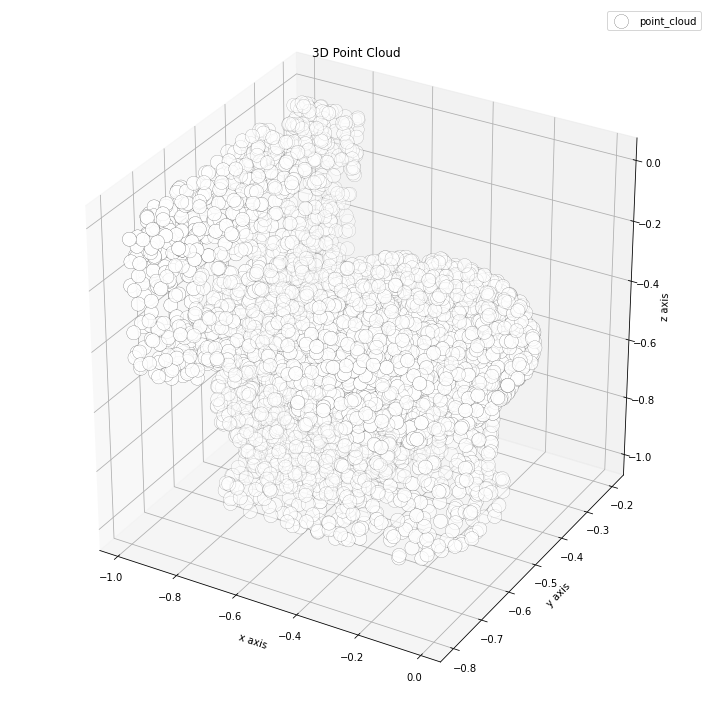

In [ ]:
# Point Cloud:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')
angle =30
scaled_matrix = (samples_train[42] * -1)
x1 = scaled_matrix[:,0]
y1 = scaled_matrix[:,1]
z1 = scaled_matrix[:,2]

ax.scatter3D(z1, y1, x1, zdir='z', c='w', marker='o', label='point_cloud',sizes=(200,),edgecolors=("black",),linewidths=(0.2,),)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.title("3D Point Cloud")
plt.legend()
plt.tight_layout()
plt.show()






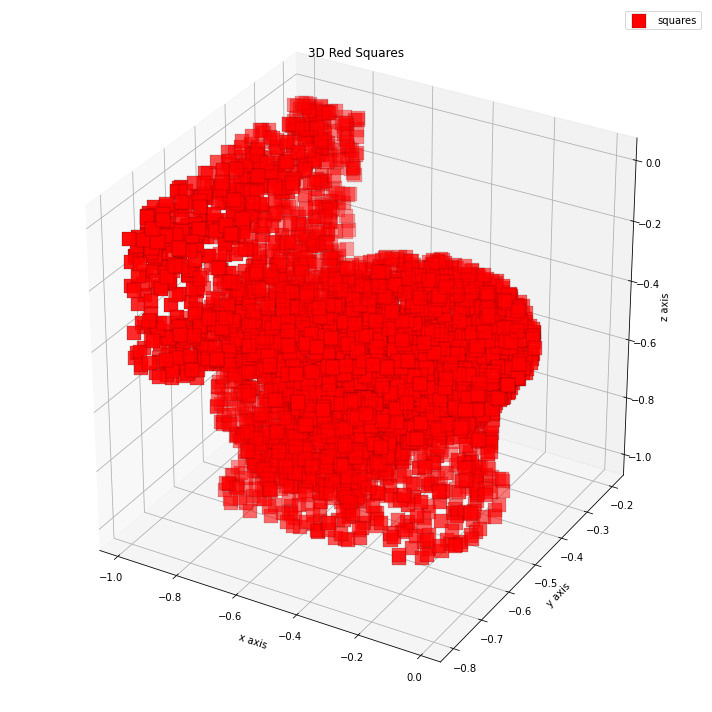

In [ ]:
# Red Squares:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection = '3d')
scaled_matrix = (samples_train[42]*-1)
x1 = scaled_matrix[:,0]
y1 = scaled_matrix[:,1]
z1 = scaled_matrix[:,2]

ax.scatter3D(z1, y1, x1, zdir='z', c='r', marker='s', label='squares',sizes=(200,),edgecolors=("black",),linewidths=(0.2,),)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
plt.title("3D Red Squares")
plt.legend()
plt.tight_layout()
plt.show()

TASK2

In [ ]:
def vol2depthmap(v, bg_val=40.):
    output = v.argmax(2)
    output[output == 0] = bg_val
    return output

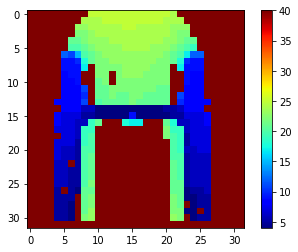

In [ ]:
sample = samples_train[9]
volume = pointcloud2volume(sample)
depth_map = vol2depthmap(volume)


plt.imshow(depth_map, cmap='jet')
plt.colorbar()

TASK3

In [ ]:
def buildoutputds(samples):
  print('Build Dataset')
  return np.array([vol2depthmap(pointcloud2volume(sample)) for sample in samples])

TASK4

In [ ]:
batch_size = 128
num_classes = 10 
epochs = 12

# input image dimensions
img_rows, img_cols = 32,32 

def train(x_train, x_test, y_train , y_test): 
  print('Train')
  if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
  else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



  x_train = keras.utils.normalize(x_train, axis=1 ) 
  x_test = keras.utils.normalize(x_test, axis=1 ) 
  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

MAIN:

In [ ]:
def main():
  # create x_train
  x_train = buildoutputds(samples_train)
  # create x_test
  x_test = buildoutputds(samples_test)

  train(x_train, x_test,labels_train,labels_test)

  print('Training is complete')

if __name__ == "__main__":
    main()



Build Dataset
Build Dataset
Train
x_train shape: (3991, 32, 32, 1)
3991 train samples
908 test samples
Train on 3991 samples, validate on 908 samples
Epoch 1/12
3991/3991 [==============================] - 13s 3ms/step - loss: 1.9982 - accuracy: 0.3072 - val_loss: 2.1639 - val_accuracy: 0.3315
Epoch 2/12
3991/3991 [==============================] - 13s 3ms/step - loss: 1.3162 - accuracy: 0.5813 - val_loss: 1.3096 - val_accuracy: 0.5573
Epoch 3/12
3991/3991 [==============================] - 13s 3ms/step - loss: 0.9413 - accuracy: 0.7008 - val_loss: 1.3647 - val_accuracy: 0.5485
Epoch 4/12
3991/3991 [==============================] - 13s 3ms/step - loss: 0.7856 - accuracy: 0.7459 - val_loss: 0.9556 - val_accuracy: 0.6773
Epoch 5/12
3991/3991 [==============================] - 13s 3ms/step - loss: 0.6918 - accuracy: 0.7825 - val_loss: 0.8964 - val_accuracy: 0.7126
Epoch 6/12
3991/3991 [==============================] - 13s 3ms/step - loss: 0.6426 - accuracy: 0.7890 - val_loss: 0.7717 - v

**Multi**-Views

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
samples_train shape: (3991, 4000, 3), labels_train shape: (3991,)
samples_train shape: (908, 4000, 3), labels_train shape: (908,)
build_inputs finished in 00:00:09 
build_inputs finished in 00:00:02 
Train
(3991, 12, 32, 32)
x_train shape: (3991, 12, 32, 32, 1)
3991 train samples
908 test samples
Train on 3991 samples, validate on 908 samples
Epoch 1/12
3991/3991 [==============================] - 75s 19ms/step - loss: 0.2458 - accuracy: 0.9192 - val_loss: 0.2559 - val_accuracy: 0.9000
Epoch 2/12
3991/3991 [==============================] - 68s 17ms/step - loss: 0.1167 - accuracy: 0.9581 - val_loss: 0.1245 - val_accuracy: 0.9535
Epoch 3/12
3991/3991 [==============================] - 70s 18ms/step - loss: 0.0944 - accuracy: 0.9656 - val_loss: 0.1239 - val_accuracy: 0.9528
Epoch 4/12
3991/3991 [==============================] - 74s 19ms/step - loss: 0.0800 - a

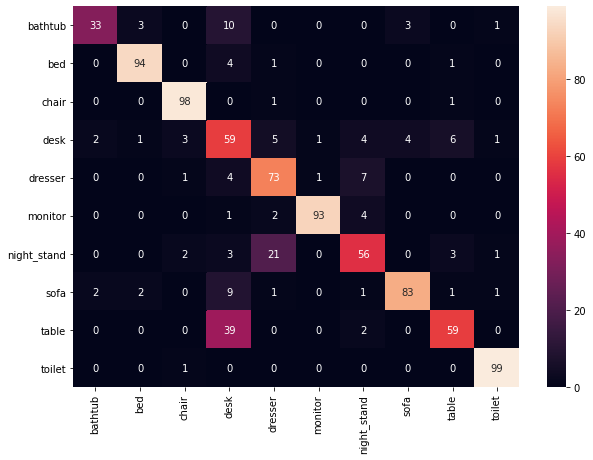

In [ ]:
import keras
import time
import functools
from google.colab import drive


drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from time import gmtime
from time import strftime

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import plot_confusion_matrix

ds_train = np.load('/content/drive/My Drive/Advanced Computer Graphic/assignment1_files/modelnet10_train.npz')

samples_train = ds_train['samples']
labels_train = ds_train['labels']
print("samples_train shape: %s, labels_train shape: %s" %(samples_train.shape, labels_train.shape))

ds_test = np.load('/content/drive/My Drive/Advanced Computer Graphic/assignment1_files/modelnet10_val.npz')
samples_test = ds_test['samples']
labels_test = ds_test['labels']
print("samples_train shape: %s, labels_train shape: %s" %(samples_test.shape, labels_test.shape))

# reference to https://stackoverflow.com/questions/5478351/python-time-measure-function
def timeit(func):
  @functools.wraps(func)
  def newfunc(*args, **kwargs):
      startTime = time.time()
      value = func(*args, **kwargs)
      elapsedTime = time.time() - startTime
      print('{} finished in {} '.format(func.__name__, 
                strftime("%H:%M:%S", gmtime(elapsedTime))))
      return value
  return newfunc


def pointcloud2volume(pc, dim=32):
    scaled_matrix = pc*(dim-1)    # now all numbers went from [0,1] to [0,dim-1]
    scaled_matrix = scaled_matrix.astype(int)    # now all numbers are integers    
    vol = np.zeros((dim,dim,dim))    # matrix full of zeros
    vol[scaled_matrix[:,0],scaled_matrix[:,1],scaled_matrix[:,2]] = 1
    return vol

def vol2depthmap(v, bg_val=40.):
    output = v.argmax(2)
    output[output == 0] = bg_val
    return output

rotation_matrices =([(lambda angle : np.array([[1,0,0],
                        [0,np.cos(angle),-np.sin(angle)],
                        [0,np.sin(angle),np.cos(angle)]]))(30*i) 
    for i in range(12)])



def normalize_matrix(matrix):
  return np.where(matrix > 0, np.where(matrix <= 1, matrix, 0), 0)
       
def create_all_views(sample):
    return [vol2depthmap(pointcloud2volume(normalize_matrix(rotation_matrix.dot(sample.T).T))) 
      for rotation_matrix in rotation_matrices]

@timeit
def build_inputs(samples, length):
    return [create_all_views(samples[i]) for i in range(length)]

class SplitLayer(keras.layers.Layer):
    def __init__(self, num_splits, **kwargs):
        self.num_splits = num_splits
        super(SplitLayer, self).__init__(**kwargs)
     
     # Defines the computation from inputs to outputs.
    def call(self, x):
        return [x[:, i] for i in range(self.num_splits)]

    # Computes the output shape of the layer.
    def compute_output_shape(self, input_shape):
        return [(input_shape[0],) + input_shape[2:]]*self.num_splits


batch_size = 128
num_classes = 10 
epochs = 12
num_views = 12
img_rows, img_cols = 32,32 
input_shape = (img_rows, img_cols, 1)

def print_cm(cm):
  labels = ['bathtub', 'bed', 'chair', 'desk', 'dresser','monitor', 'night_stand', 'sofa', 'table', 'toilet']
  df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)

@timeit
def train_multi(x_train, x_test, y_train , y_test): 
  print('Train')
  print(x_train.shape)
  if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
  else:
    x_train = x_train.reshape(x_train.shape[0], num_views, img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0], num_views, img_rows, img_cols,1)
  

  x_train = keras.utils.normalize(x_train, axis=1 ) 
  x_test = keras.utils.normalize(x_test, axis=1 ) 
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=input_shape))
  #check next two lines if needed
  #CNN1
  model.add(keras.layers.BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
 

  input = keras.layers.Input((num_views, 32, 32, 1))
  views = SplitLayer(num_views)(input) # list of keras-tensors
  pooled_views = keras.layers.Maximum()([model(view) for view in views])

  #CNN2
  CNN2 = Dropout(0.25)(pooled_views) 
  CNN2 = keras.layers.Dense(128)(CNN2)
  CNN2 = Dropout(0.5)(CNN2) 
  CNN2 = Dense(num_classes, activation='softmax')(CNN2)
  model = keras.models.Model(input, CNN2)

  model.compile(loss=keras.losses.binary_crossentropy,
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, verbose=0)
  predictions = model.predict(x_test,batch_size=batch_size, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  cm = confusion_matrix(labels_test,predictions.argmax(axis=-1))
  print(cm)
  print_cm(cm)
  


if __name__ == "__main__":
  shapes_number = 3991 
  x_train = np.asarray(build_inputs(samples_train,shapes_number))
  x_test = np.asarray(build_inputs(samples_test,908))
  train_multi(x_train, x_test,labels_train,labels_test)
  

Creative mode

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
samples_train shape: (3991, 4000, 3), labels_train shape: (3991,)
samples_train shape: (908, 4000, 3), labels_train shape: (908,)
Train
(3991, 36, 32, 32)
x_train shape: (3991, 36, 32, 32, 1)
3991 train samples
908 test samples
Train on 3991 samples, validate on 908 samples
Epoch 1/12
3991/3991 [==============================] - 229s 57ms/step - loss: 0.3393 - accuracy: 0.8962 - val_loss: 0.2210 - val_accuracy: 0.9228
Epoch 2/12
3991/3991 [==============================] - 224s 56ms/step - loss: 0.1445 - accuracy: 0.9467 - val_loss: 0.1442 - val_accuracy: 0.9507
Epoch 3/12
3991/3991 [==============================] - 217s 54ms/step - loss: 0.1051 - accuracy: 0.9612 - val_loss: 0.1181 - val_accuracy: 0.9542
Epoch 4/12
3991/3991 [==============================] - 217s 54ms/step - loss: 0.0882 - accuracy: 0.9676 - val_loss: 0.1117 - val_accuracy: 0.9615
Epoch 5/

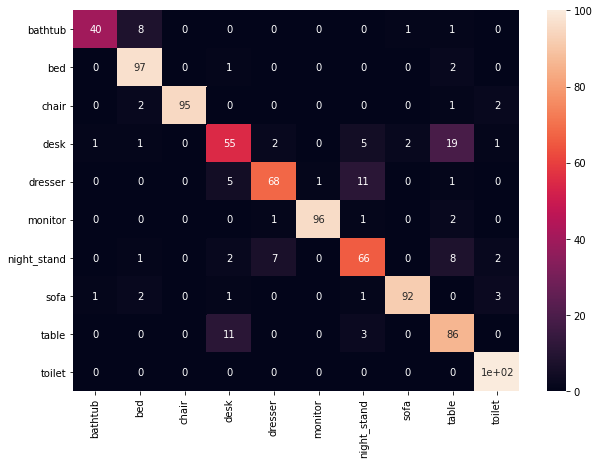

In [ ]:
import keras
import time
import functools
from google.colab import drive


drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from time import gmtime
from time import strftime

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from sklearn.metrics import plot_confusion_matrix

ds_train = np.load('/content/drive/My Drive/Advanced Computer Graphic/assignment1_files/modelnet10_train.npz')

samples_train = ds_train['samples']
labels_train = ds_train['labels']
print("samples_train shape: %s, labels_train shape: %s" %(samples_train.shape, labels_train.shape))

ds_test = np.load('/content/drive/My Drive/Advanced Computer Graphic/assignment1_files/modelnet10_val.npz')
samples_test = ds_test['samples']
labels_test = ds_test['labels']
print("samples_train shape: %s, labels_train shape: %s" %(samples_test.shape, labels_test.shape))

# reference to https://stackoverflow.com/questions/5478351/python-time-measure-function
def timeit(func):
  @functools.wraps(func)
  def newfunc(*args, **kwargs):
      startTime = time.time()
      value = func(*args, **kwargs)
      elapsedTime = time.time() - startTime
      print('{} finished in {} '.format(func.__name__, 
                strftime("%H:%M:%S", gmtime(elapsedTime))))
      return value
  return newfunc

def pointcloud2volume(pc, dim=32):
    scaled_matrix = pc*(dim-1)    # now all numbers went from [0,1] to [0,dim-1]
    scaled_matrix = scaled_matrix.astype(int)    # now all numbers are integers    
    vol = np.zeros((dim,dim,dim))    # matrix full of zeros
    vol[scaled_matrix[:,0],scaled_matrix[:,1],scaled_matrix[:,2]] = 1
    return vol

def vol2depthmap(v, bg_val=40.):
    output = v.argmax(2)
    output[output == 0] = bg_val
    return output

matrix_x = (lambda angle : 
            np.array([[1,0,0],
                    [0,np.cos(angle),-np.sin(angle)],
                    [0,np.sin(angle),np.cos(angle)]])) 

matrix_y = (lambda angle :np.array([[np.cos(angle),0,np.sin(angle)],
                    [0,1,0],
                    [-np.sin(angle),0,np.cos(angle)]]))  

matrix_z = (lambda angle : np.array([[np.cos(angle),-np.sin(angle),0],
                    [np.sin(angle),np.cos(angle),0],
                    [0,0,1]] ))

rotation_matrices = [matrix(30*i) for i in range(12) for matrix in [matrix_x,matrix_y,matrix_z]]


def normalize_matrix(matrix):
  return np.where(matrix > 0, np.where(matrix <= 1, matrix, 0), 0)
       
def create_all_views(sample):
    return [vol2depthmap(pointcloud2volume(normalize_matrix(rotation_matrix.dot(sample.T).T))) for rotation_matrix in rotation_matrices]

@timeit
def build_inputs(samples, length):
    return [create_all_views(samples[i]) for i in range(length)]


class SplitLayer(keras.layers.Layer):
    def __init__(self, num_splits, **kwargs):
        self.num_splits = num_splits
        super(SplitLayer, self).__init__(**kwargs)
     
     # Defines the computation from inputs to outputs.
    def call(self, x):
        return [x[:, i] for i in range(self.num_splits)]

    # Computes the output shape of the layer.
    def compute_output_shape(self, input_shape):
        return [(input_shape[0],) + input_shape[2:]]*self.num_splits

batch_size = 128
num_classes = 10 
epochs = 12
num_views = 36
img_rows, img_cols = 32,32 
input_shape = (img_rows, img_cols, 1)

def print_cm(cm):
  labels = ['bathtub', 'bed', 'chair', 'desk', 'dresser','monitor', 'night_stand', 'sofa', 'table', 'toilet']
  df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)

@timeit
def train_multi(x_train, x_test, y_train , y_test): 
  print('Train')
  print(x_train.shape)
  if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
  else:
    x_train = x_train.reshape(x_train.shape[0], num_views, img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0], num_views, img_rows, img_cols,1)
  

  x_train = keras.utils.normalize(x_train, axis=1 ) 
  x_test = keras.utils.normalize(x_test, axis=1 ) 
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')

  print('x_train shape:', x_train.shape)
  print(x_train.shape[0], 'train samples')
  print(x_test.shape[0], 'test samples')

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=input_shape))
  #check next two lines if needed
  #CNN1
  model.add(keras.layers.BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
 

  input = keras.layers.Input((num_views, 32, 32, 1))
  views = SplitLayer(num_views)(input) # list of keras-tensors
  pooled_views = keras.layers.Maximum()([model(view) for view in views])

  #CNN2
  CNN2 = Dropout(0.25)(pooled_views) 
  CNN2 = keras.layers.Dense(128)(CNN2)
  CNN2 = Dropout(0.5)(CNN2) 
  CNN2 = Dense(num_classes, activation='softmax')(CNN2)
  model = keras.models.Model(input, CNN2)

  model.compile(loss=keras.losses.binary_crossentropy,
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test))
  score = model.evaluate(x_test, y_test, verbose=0)
  predictions = model.predict(x_test,batch_size=batch_size, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  cm = confusion_matrix(labels_test,predictions.argmax(axis=-1))
  print(cm)
  print_cm(cm)
  


if __name__ == "__main__":
  shapes_number = 3991 
  x_train = np.asarray(build_inputs(samples_train,shapes_number))
  x_test = np.asarray(build_inputs(samples_test,908))
  train_multi(x_train, x_test,labels_train,labels_test)